In [73]:
from torch.utils.data import Dataset
from collections import defaultdict
from random import choice
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class _BNReluConv(nn.Sequential):
    def __init__(self, num_maps_in, num_maps_out, k=3, bias=True):
        super(_BNReluConv, self).__init__()
        self.append(torch.nn.BatchNorm2d(num_maps_in, affine=bias))
        self.append(torch.nn.ReLU())
        self.append(torch.nn.Conv2d(num_maps_in, num_maps_out, kernel_size=k))


class SimpleMetricEmbedding(nn.Module):
    def __init__(self, input_channels, emb_size=32):
        super().__init__()
        self.emb_size = emb_size
        self.block_1 = _BNReluConv(input_channels, emb_size)
        self.maxpool_1 = torch.nn.MaxPool2d(kernel_size=3, stride=2)
        self.block_2 = _BNReluConv(emb_size, emb_size)
        self.maxpool_2 = torch.nn.MaxPool2d(kernel_size=3, stride=2)
        self.block_3 = _BNReluConv(emb_size, emb_size)
        self.avg_global = nn.AvgPool2d(kernel_size=2)
        self.margin = 1

    def get_features(self, img: torch.Tensor):
        x = self.block_1(img)
        x = self.maxpool_1(x)
        x = self.block_2(x)
        x = self.maxpool_2(x)
        x = self.block_3(x)
        x = self.avg_global(x)
        x = x.reshape((img.size(dim=0), self.emb_size))
        return x

    def loss(self, anchor, positive, negative):
        a_x = self.get_features(anchor)
        p_x = self.get_features(positive)
        n_x = self.get_features(negative)
        distance_positive = F.pairwise_distance(a_x, p_x, p=2)
        distance_negative = F.pairwise_distance(a_x, n_x, p=2)
        loss = torch.maximum(torch.tensor(0), distance_positive - distance_negative + self.margin)
        loss = torch.mean(loss)
        return loss


In [75]:
class MNISTMetricDataset(Dataset):
    def __init__(self, root="/tmp/mnist/", split='train'):
        super().__init__()
        assert split in ['train', 'test', 'traineval']
        self.root = root
        self.split = split
        mnist_ds = torchvision.datasets.MNIST(self.root, train='train' in split, download=True)
        self.images, self.targets = mnist_ds.data.float() / 255., mnist_ds.targets
        self.classes = list(range(10))

        self.target2indices = defaultdict(list)
        for i in range(len(self.images)):
            self.target2indices[self.targets[i].item()] += [i]

    def _sample_negative(self, index):
        # YOUR CODE HERE
        """
        returns index of a random negative example
        """
        target=self.targets[index].item()
        negative_indices=[]
        t2i=self.target2indices
        for key in t2i.keys():
            if key!=target:
                negative_indices.extend(t2i[key])
        return choice(negative_indices)


    def _sample_positive(self, index):
        # YOUR CODE HERE
        """
        returns index of a random positive example
        """
        target=self.targets[index].item()
        positive_indices=self.target2indices[target]
        return choice(positive_indices)


    def __getitem__(self, index):
        anchor = self.images[index].unsqueeze(0)
        target_id = self.targets[index].item()
        if self.split in ['traineval', 'val', 'test']:
            return anchor, target_id
        else:
            positive = self._sample_positive(index)
            negative = self._sample_negative(index)
            positive = self.images[positive]
            negative = self.images[negative]
            return anchor, positive.unsqueeze(0), negative.unsqueeze(0), target_id

In [76]:
mnist=MNISTMetricDataset()

In [82]:
imgs=mnist.images
tar=mnist.targets
cl=mnist.classes
t2i=mnist.target2indices

t2i_3=t2i[3]
trice=imgs[t2i_3]

t2i_ne_3=[]
print(t2i.keys())

dict_keys([5, 0, 4, 1, 9, 2, 3, 6, 7, 8])


In [83]:
model=SimpleMetricEmbedding(1, 32)
model.get_features(mnist[4])

AttributeError: 'tuple' object has no attribute 'dim'

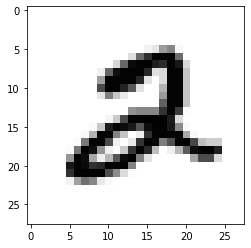

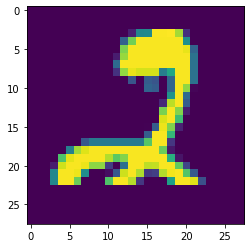

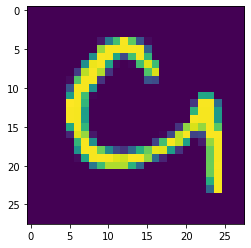

2


In [81]:
a,pos, neg, target=mnist[5]
plt.imshow(-1* a.squeeze(), cmap='gray')
plt.show()
plt.imshow(pos.squeeze())
plt.show()
plt.imshow(neg.squeeze())
plt.show()
print(target)
